# Import and Check OS

In [2]:
import sys


import cv2
import keras
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
import scipy.ndimage as nd

Using TensorFlow backend.


In [3]:
def change_contrast_brightness(image, alpha, beta):
    """
    https://docs.opencv.org/3.4/d3/dc1/tutorial_basic_linear_transform.html
    """
    new_image = np.zeros(image.shape, image.dtype)
    
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            for c in range(image.shape[2]):
                new_image[y,x,c] = np.clip(alpha*image[y,x,c] + beta, 0, 255)
    return new_image

def gamma_adjustment(img_original, gamma):
    """
    https://docs.opencv.org/3.4/d3/dc1/tutorial_basic_linear_transform.html
    """
    lookUpTable = np.empty((1,256), np.uint8)
    for i in range(256):
        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
    res = cv2.LUT(img_original, lookUpTable)
    return res

In [4]:
if 'win32' in sys.platform:
    ex_filepath = 'F:\Colonies_Data\data\plate 2_24.png'
if 'darwin' in sys.platform:
    ex_filepath = "/Volumes/Samsung_T5/Colonies_Data/data/plate 2_24.png"

# Find the plate

## Find position and radius of the plate

In [5]:
# https://www.pyimagesearch.com/2014/07/21/detecting-circles-images-using-opencv-hough-circles/
ex_filepath = "/Volumes/Samsung_T5/Segmentation_Data/VC0395_300mOsm_12.JPG"
IMG_SIZE = 1000

image = cv2.imread(ex_filepath)
image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
output = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, minDist=int(IMG_SIZE/3), dp=2, minRadius=int(IMG_SIZE/3), maxRadius=int(IMG_SIZE/2))
 
    
if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
    circle_ = np.round(circles[0, :]).astype("int")
    print(circle_)
    # loop over the (x, y) coordinates and radius of the circles
    x, y, r = circle_[0]


[[525 461 470]]


## Extract the plate

In [ ]:
img = Image.open(ex_filepath).convert("RGB").resize((1000,1000))

npImage=np.array(img)
image = change_contrast_brightness(npImage, .8, 10)

# Create same size alpha layer with circle
alpha = Image.new('L', img.size,0)
draw = ImageDraw.Draw(alpha)
draw.pieslice([x-r, y-r, x+r, y+r],0,360,fill=255)

# Convert alpha Image to numpy array
npAlpha=np.array(alpha)

# Add alpha layer to RGB
npImage=np.dstack((image,npAlpha))

# Save with alpha
Image.fromarray(npImage).save('result.png')

# Find Small circles

In [ ]:
image = cv2.imread('result.png', cv2.IMREAD_UNCHANGED)
image2 = cv2.bitwise_not(image[:,:,:3])
output = image2.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, minDist=1, dp=2, minRadius=10, maxRadius=25, param2=37)
 
    
if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
    circle_ = np.round(circles[0, :]).astype("int")
    print(circle_)
    # loop over the (x, y) coordinates and radius of the circles
    for (x, y, r) in circle_:
        # draw the circle in the output image, then draw a rectangle
        # corresponding to the center of the circle
        cv2.circle(output, (x, y), r, (0, 255, 0), 4)
        cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
 
    # show the output image
#     cv2.imshow("output", np.hstack([image2, output]))
#     cv2.waitKey(0)

In [10]:
def complete_fit(filepath, template, res_img1:str, res_img2:str, threshold=0.5):
    img = cv2.imread(filepath,0)
    img_rgb = cv2.imread(filepath)
    img_rgb2 = img_rgb.copy()
    img_rgb3 = img_rgb.copy()
    template_ = cv2.imread(template, 0)
    w, h = template_.shape[::-1]
    loc = create_init_image(img_rgb, template_, threshold=threshold, res_img=res_img1) 
    matches = list(zip(*loc[::-1]))
    matches = sorted(matches, key=lambda x:x[0])
    unique_locs = find_unique_locs(matches, w, h)
    merged_locs = find_merged_locs(unique_locs, w, h)
    merged_locs = find_merged_locs(merged_locs, w, h)
    create_final_image(img_rgb2, merged_locs, res_img=res_img2)
    colonies = extract_colonies(img_rgb3, merged_locs)
    return colonies

In [11]:
def create_init_image(img_rgb, template, threshold, res_img):
    """
    Creates the initial image, with all matches to the template outlined in red.
    Inputs:
        img_rgb: array of the image to highlight
        template: template subimage to find in img_rgb
        threshold: Threshold for the template matching algorithm
        res_img1: filename to save the resulting image to.
    Returns: None
    """
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    w, h = template.shape[::-1]
    res = cv2.matchTemplate(img_gray, template, cv2.TM_CCOEFF_NORMED)
    threshold = threshold
    loc = np.where(res >= threshold)
    for pt in zip(*loc[::-1]):
        cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)
    cv2.imwrite(res_img, img_rgb)
    return loc


def find_unique_locs(matches, w, h):
    """
    Takes all matches to the template and returns a smaller set of boxes with additional space between them.
    Inputs:
        matches: a list of tuples containing a all matches to the template in the image.
    Returns:
        unique_locs: list of tuples containing less-overlapped boundary boxes
    """
    unique_locs = []
    current_loc = matches[0]
    curr_lim = matches[0]
    for i, match in enumerate(matches):
        if ((match[0] < current_loc[0] + w)
            and(match[1] < current_loc[1] + h)
            and(match[0] >= current_loc[0])
                and((match[1] >= current_loc[1] - h) and (match[1] <= current_loc[1] + h))):
            current_lim = match
        else:
            unique_locs.append(
                (current_loc, (current_loc[0] + w, current_loc[1] + h)))
            current_loc = match
            unique_locs.append(
                (current_loc, (current_loc[0] + w, current_loc[1] + h)))
            curr_lim = match
    return unique_locs


def find_merged_locs(unique_locs, w, h):
    """
    Merges overlapping boundary boxes of colonies.
    Inputs: 
        unique_locs: list of tuples containing data about the unique boundary boxes for colonies.
    Returns:
        merged_locs: list of tuples containing data about the boundary boxes for colonies, with 
            nearby boxes merged with one another.
    """
    merged_locs = []
    locs_to_skip = []
    true_unique_locs = unique_locs.copy()
    for location1 in true_unique_locs:
        merge_count = 0
        close_boxes = []
        if location1 in locs_to_skip:
            continue
        for location2 in true_unique_locs:
            if (location1 != location2) and is_close(location1, location2):
                close_boxes.append(location2)
                locs_to_skip.append(location2)
                merge_count += 1
        if not close_boxes:
            merged_locs.append(location1)
        else:
            farthest_box = find_farthest(location1, close_boxes)
            merged_locs.append(merge_boxes(location1, farthest_box))
    merged_locs = list(set(merged_locs))
    return merged_locs


def create_final_image(img, merged_locs, res_img):
    """
    Creates the final image of the merged boundary boxes around colonies.
    Inputs:
        img: a numpy array of pixel intensities that make up the image.
        merged_locs: set of merged boundary boxes for identified colonies.
        res_img: file name to save resulting image to.
    Returns: None
    """
    for ul in merged_locs:
        upper_left, lower_right = ul[0], ul[1]
        cv2.rectangle(img, upper_left, lower_right, (0, 255, 0), 4)
    cv2.imwrite(res_img, img)


def extract_colonies(img, boxes):
    """
    Gives arrays (to be converted to images) of all found colonies on the dish.
    Inputs:
        img:base image containing colonies.
        boxes: locations of boxes containing colonies.
    Returns:
        colonies: arrays (to be converted to images) containing supposed colonies.
    """
    colonies = []
    for box in boxes:
        y1 = box[0][0]
        x1 = box[0][1]
        y2 = box[1][0]
        x2 = box[1][1]
        sub_image = img[x1:x2+1, y1:y2+1,:]
        colonies.append(sub_image)
    return colonies

def is_close(loc1, loc2, w=100, h=100):
    loc1_f = np.array(loc1[1])
    loc2_f = np.array(loc2[1])
    diag_of_rect = np.sqrt(w ** 2 + h ** 2)
    if np.linalg.norm(loc1_f - loc2_f, 2) <  diag_of_rect:# max(w, h):
        return True
    else:
        return False
    
def merge_boxes(box_1, box_2):
    new_box_x1 = min(box_1[0][0], box_2[0][0])
    new_box_x2 = max(box_1[1][0], box_2[1][0])
    new_box_y1 = min(box_1[0][1], box_2[0][1])
    new_box_y2 = max(box_1[1][1], box_2[1][1])
    new_box = ((new_box_x1, new_box_y1), (new_box_x2, new_box_y2))
    return new_box


def overlap(box_1, box_2):
    x11 = box_1[0][0]
    y11 = box_1[0][1]
    x12 = box_1[1][0]
    y12 = box_1[1][1]
    x21 = box_2[0][0]
    y21 = box_2[0][1]
    x22 = box_2[1][0]
    y22 = box_2[1][1]
    if ((((x21 <= x12) and (x22 >= x12) and (y21 >= y12) and (y22 <= y12))) 
        or ((x21 >= x12) and (x22 <= x12) and (y21 <= y12) and (y22 >= y12))
        or ((x11 >=x21) and (x11 <= x22) and (y11<= y21) and (y12 >= y21))
        or ((x11 >= x21) and (x11 <= x22) and (y11 >= y21) and (y11 <= y22))):
            return True
    else:
        return False
    
    
def find_farthest(box_1, other_boxes):
    dists = []
    for ob in other_boxes:
        box_1_array = np.array(box_1[0])
        ob_array = np.array(ob[0])
        dists.append(np.linalg.norm(box_1_array - ob_array, 2))
    farthest_idx = dists.index(max(dists))
    return other_boxes[farthest_idx]

def find_max_boxes(locs, w, h):
    loc_1 = locs[0]
    loc_2 = locs[1]
    upper_left = (min(loc_1[0], loc_2[0]), max(loc_1[1], loc_2[1]))
    lower_right = (max(loc_1[0], loc_2[0]) , max(loc_1[1], loc_2[1]) - h)
    return (upper_left, lower_right)


### Plate 1

In [ ]:
mc12 = complete_fit("/Volumes/Samsung_T5/Segmentation_Data/VC0395_300mOsm_12.JPG", 
             "/Volumes/Samsung_T5/Segmentation_Data/Individual_Colonies/VC0395_300mOsm_12_colony.JPG",
             "res_12.png",
             "res_12_count.png", threshold=0.6)

In [ ]:
for colony in mc12:
    plt.figure()
    plt.imshow(colony)

### Plate 2

In [4]:
mc2 = complete_fit("/Volumes/Samsung_T5/Colonies_Data/data/plate 81_50.png", 
             "/Volumes/Samsung_T5/Segmentation_Data/Individual_Colonies/plate 81_50_Colony.png",
             "res_81.png",
             "res_81_count.png", threshold=0.75)

### Plate 3

In [13]:
mc3 = complete_fit("/Volumes/Samsung_T5/Segmentation_Data/Sukharev_Lab_Data/plates/MJF465_400mOsm_37(1).JPG",
                   "/Volumes/Samsung_T5/Segmentation_Data/Sukharev_Lab_Data/colonies/MJF465_400mOsm_37(1)_colony.jpg",
                   "res_37(1).png",
                   "res_37(1)_count.png", 
                   threshold=0.6)

/Users/anthonyschams/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


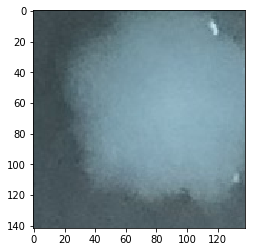

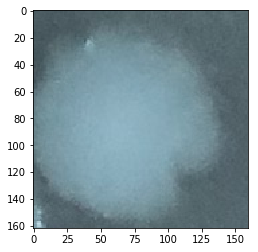

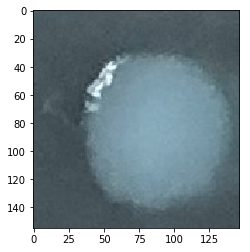

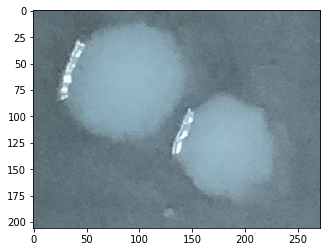

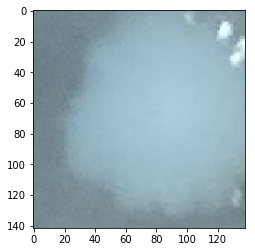

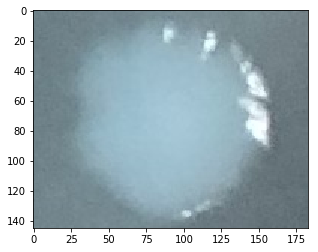

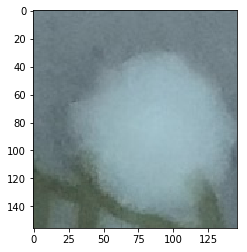

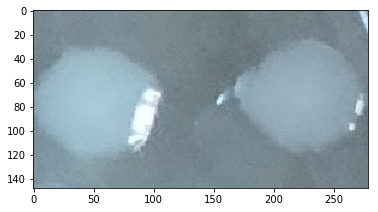

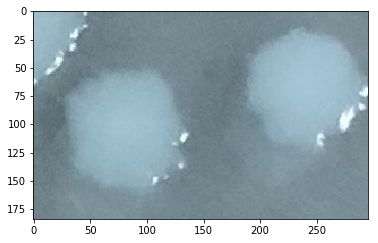

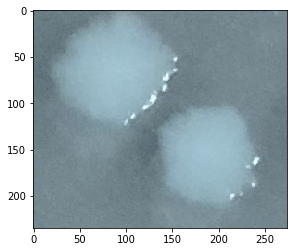

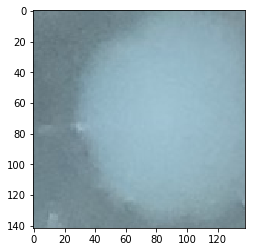

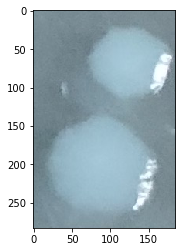

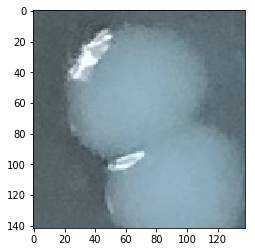

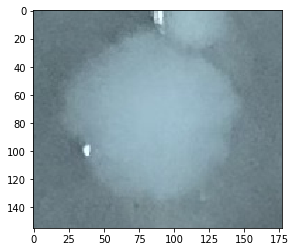

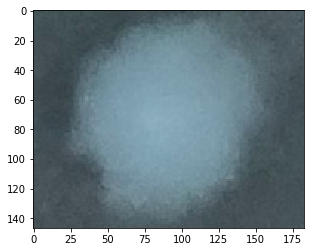

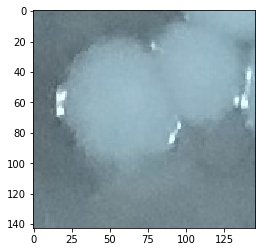

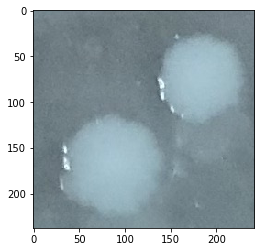

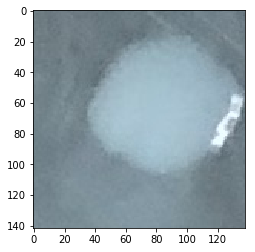

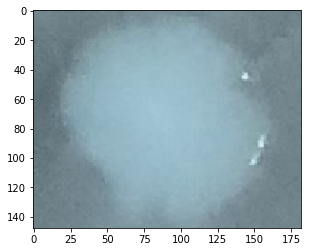

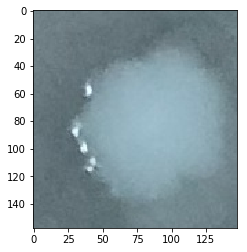

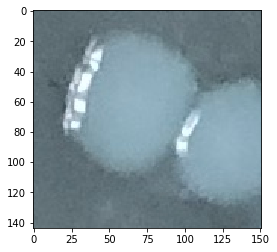

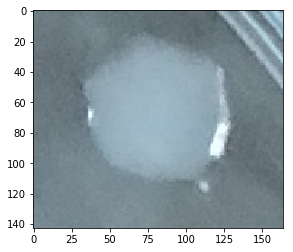

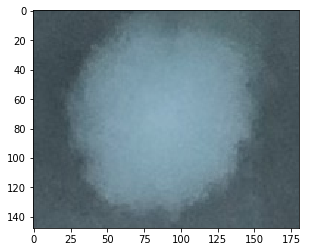

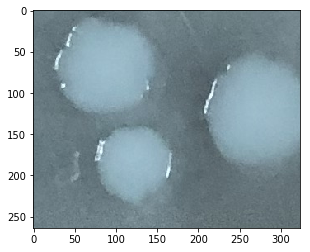

In [26]:
for colony in mc3:
    plt.figure()
    plt.imshow(colony)

## Feed into NN

In [35]:
model = keras.models.load_model('grayscale_model.hdf5')

In [37]:
for i in range(len(mc3)):
    ex = mc3[i]
    ex = cv2.resize(ex, dsize=(128,128))
    ex = ex.reshape([-1, 128, 128, 1])
    print(model.predict(ex)[0][0])

0.98488545
0.6460014
0.0824715
0.97032803
0.9998902
0.99921954
0.4963332
0.97000164
0.99840504
0.9997414
0.99958724
0.99998915
0.9646579
0.95970154
0.6787831
0.9993425
0.9983411
0.9942405
0.9987739
0.466043
0.93687445
0.96514523
0.7468167
0.98607963


In [13]:
for layer in model.layers:
    print(layer.input_shape)

(None, 128, 128, 3)
(None, 124, 124, 20)
(None, 124, 124, 20)
(None, 62, 62, 20)
(None, 58, 58, 50)
(None, 58, 58, 50)
(None, 29, 29, 50)
(None, 26, 26, 100)
(None, 13, 13, 100)
(None, 10, 10, 200)
(None, 5, 5, 200)
(None, 5, 5, 200)
(None, 5000)
(None, 500)
(None, 500)
(None, 7)


In [30]:
len(mc3)

24